# Problem Background
* Data Challenge from XXX Insurance Company 
* XXX is a B2B insurance company offering employee benefits products to employers across the US and UK. These services include: 
    * Life insurance 
    * Disability insurance
    * Workplace injury insurance
* The Corporate Marketing Analytics Team wants to identify high potential targets for sales of **ProductX**
* Real world data provided on employer characteristics, sales activity, and geographic location
* Design model for recommending **ProductX** given the data provided

**My Approach**

* Predict sale success ("sold" or "lost") of **ProductX**  based on features provided
* Additional data and resources used:
    * [US Census Bureau: County Business Patterns - 2017](https://www.census.gov/data/datasets/2017/econ/cbp/2017-cbp.html) 
    * [OECD: Enterprises by business size definition](https://data.oecd.org/entrepreneur/enterprises-by-business-size.htm)

In [1]:
# For File manangement
import sys as sys
import os as os

# For data manipulations
import pandas as pd
import numpy as np

# For visualizations
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D

# For splitting, cross validating, standardizing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
os.getcwd()

'/Users/oliver/Desktop/Brandeis/Career/Unum'

In [3]:
# Employers data
employers = pd.read_csv("./exercise/data/employers.csv", index_col = 'EmployerId')
employers.head()

,ClientTenure,Employees,Industry,NetworkStrength,ZipCode
EmployerId,,,,,
409551605,3,10,I12,0.5073,14301
848679,27,22,I12,-0.1249,78229
664144005,5,168,I20,-0.0671,48529
604857,25,19,I27,0.7818,45429
128777227,6,12,I19,-0.4495,16335


In [4]:
# Geography data
geography = pd.read_csv("./exercise/data/geography.csv", engine='python')
geography.head()

,zip,city,latitude,longitude,fips,county,population,state,cbsa,cbsa_name
0,210,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
1,211,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
2,212,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
3,213,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
4,214,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton


In [5]:
# Quotes data: Sales activity
quotes = pd.read_csv("./exercise/data/quotes.csv", index_col = 'EmployerId')
quotes.rename(columns = {'Status':'success'},inplace = True)
quotes.head()

,Offered,success
EmployerId,,
363773443,ProductX,Lost
186941116,ProductX,Lost
511147993,ProductX,Lost
46777684,ProductX,Lost
115068663,ProductX,Lost


In [6]:
# US Census Bureau data zipcode level data: County Business Patterns - First Quarter 2017
county_bus = pd.read_csv("./exercise/data/zbp17totals.txt")
county_bus.rename(columns = {'qp1':'tot_payroll_q1', 'ap':'tot_payroll_annual','est':'tot_employers'}, inplace = True)
county_bus = county_bus[['zip', 'tot_payroll_q1','tot_payroll_annual','tot_employers']]
county_bus.head()

,zip,tot_payroll_q1,tot_payroll_annual,tot_employers
0,1001,96616,422470,473
1,1002,70277,299103,545
2,1003,2461,10380,21
3,1004,1422,5912,12
4,1005,8163,35287,94


# Data Cleaning & Preparation

In [7]:
# Changing columns data types: Helps with merging and summary stats
geography['zip'] = geography['zip'].astype(str)
county_bus['zip'] = county_bus['zip'].astype(str)
geography['state'] = geography.state.astype('category')
employers['Industry'] = employers.Industry.astype('category')

In [8]:
# Merge files
df_combined = pd.merge(left = employers, right = quotes, how = "left", left_on = "EmployerId", right_on = "EmployerId")
df_combined = pd.merge(left = df_combined, right = geography, how = "left", left_on = "ZipCode", right_on = "zip")
df_combined = pd.merge(left = df_combined, right = county_bus, how = "left", left_on = "zip", right_on = "zip")

In [9]:
# Filter for productX
df_combined = df_combined[df_combined.Offered == 'ProductX']
# Recode success feature: Sold =1, Lost = 0
df_combined['success'] = df_combined['success'].map({'Lost': 0, 'Sold': 1})
# Replace '?' with NaN in 'NetworkStrength'
df_combined["NetworkStrength"] = df_combined["NetworkStrength"].replace("?", np.NaN)
# Recode NetworkStrength to numeric
df_combined ["NetworkStrength"] = pd.to_numeric(df_combined["NetworkStrength"])
# Binning employees based on OECD enterprise size definitions
labels_emp = ["Micro","Small","Medium","Large"]
bins_emp = [0,10,50,250,np.inf] # Max on Employees = 135940
df_combined["company_size"] = pd.cut(df_combined['Employees'], bins=bins_emp, labels=labels_emp)
# Binning annual payroll income
labels_inc = ["Low","Lower-Middle","Middle","Upper Middle", "Upper"]
quantile = [0, 0.2,0.4,0.6,0.8,1]
df_combined["income_cat"] = pd.qcut(df_combined['tot_payroll_annual'], q=quantile, labels=labels_inc)

In [11]:
# Imputation of missing values
# Replace NaNs with Unknown for Industry'
df_combined['Industry'] = df_combined['Industry'].cat.add_categories("Unknown").fillna("Unknown")
# Median imputattion for the remaining features
df_combined.fillna(df_combined.median(), inplace=True)
# Drop remaining missing values
df_combined = df_combined.dropna() 

In [12]:
# Select relevant columns
df_sum = df_combined[['success', 'NetworkStrength', 'ClientTenure', 'Employees', 'state','Industry','population','tot_payroll_q1','tot_payroll_annual','tot_employers','company_size','income_cat']]
# Export to csv
df_sum.to_csv("Unum.csv")

In [13]:
# Shape of dataframe
df_combined.shape 

(7075, 22)

In [14]:
# All numeric features
df_sum.describe()

,success,NetworkStrength,ClientTenure,Employees,population,tot_payroll_q1,tot_payroll_annual,tot_employers
count,7075.000000,7075.000000,7075.000000,7075.000000,7.075000e+03,7.075000e+03,7.075000e+03,7075.000000
mean,0.228269,0.200990,10.034346,115.457385,1.237715e+06,3.870538e+05,1.448411e+06,1075.141767
std,0.419746,0.522766,10.101833,1744.003029,1.846394e+06,6.510820e+05,2.154560e+06,758.120901
min,0.000000,-2.115100,1.000000,1.000000,9.820000e+02,0.000000e+00,0.000000e+00,4.000000
25%,0.000000,-0.112400,2.000000,16.000000,1.974650e+05,8.337750e+04,3.484930e+05,529.500000
50%,0.000000,0.240100,6.000000,31.000000,6.266810e+05,1.900980e+05,7.864350e+05,947.000000
75%,0.000000,0.573950,16.000000,66.000000,1.202362e+06,4.136790e+05,1.644682e+06,1477.000000
max,1.000000,2.537700,119.000000,135940.000000,9.818605e+06,8.525837e+06,2.436443e+07,7277.000000


In [15]:
# All categorical features
df_sum.describe(include = 'category')

,state,Industry,company_size,income_cat
count,7075,7075,7075,7075
unique,43,28,4,5
top,TX,Unknown,Small,Upper Middle
freq,933,1349,4082,1419


/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


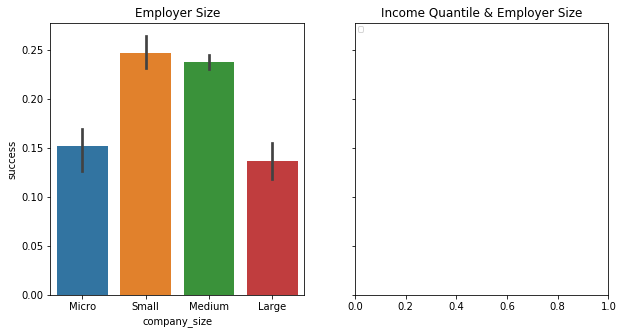

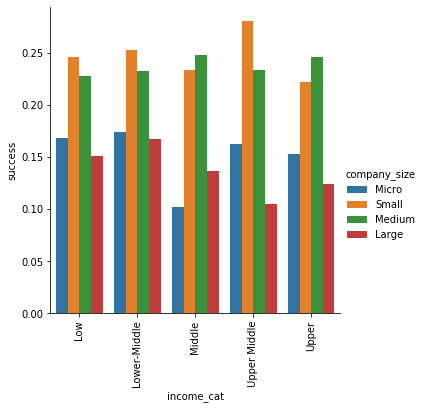

In [16]:
# Income Quantile and employer size
import gc
df_income_cat = df_sum.groupby(['income_cat', 'company_size'])['success'].aggregate(np.mean).reset_index().sort_values('success')

# Plots
f, axes = plt.subplots(1, 2, sharey =True, figsize=(10, 5))
sns.barplot(x = 'company_size', y = 'success', data = df_income_cat, ax=axes[0])
sns.catplot(x = "income_cat",   y = 'success', kind = 'bar', hue = 'company_size', data=df_income_cat, ax=axes[1])

# Aesthetics
plt.xticks(rotation=90)
plt.subplots_adjust(wspace = 0.1, hspace = 0)
axes[0].title.set_text('Employer Size')
axes[1].title.set_text('Income Quantile & Employer Size')
axes[1].legend(loc='upper left',prop={'size': 6.5})

plt.show()
plt.close()

In [17]:
# Industry
indus_result = df_sum.groupby(["Industry"])['success'].aggregate(np.mean).reset_index().sort_values('success')
# Top 20
indus_result = indus_result.tail(20)
# State
state_result = df_sum.groupby(["state"])['success'].aggregate(np.mean).reset_index().sort_values('success')
# Drop missing 'success' values
state_result = state_result.dropna() 
# Top 20
state_result = state_result.tail(20)

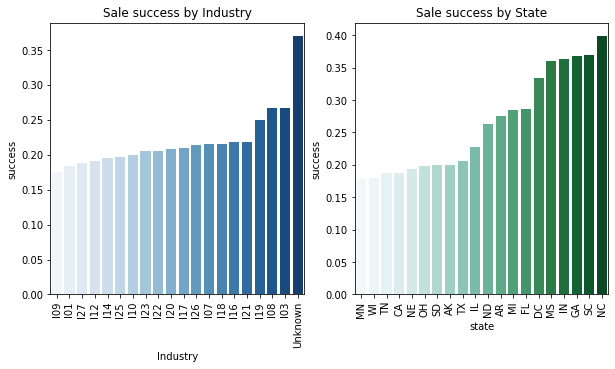

In [18]:
# Plots
plt.subplot(1,2,1)
sns.barplot(x='Industry', y='success', data=indus_result, order= indus_result['Industry'], palette= 'Blues')
plt.title("Sale success by Industry")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
state_result = state_result.tail(20)
sns.barplot(x='state', y= 'success', data=state_result, order= state_result['state'], palette= "BuGn")
plt.title("Sale success by State")
plt.xticks(rotation=90)

# Aesthetics
plt.subplots_adjust(wspace = 0.2, hspace = 0)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

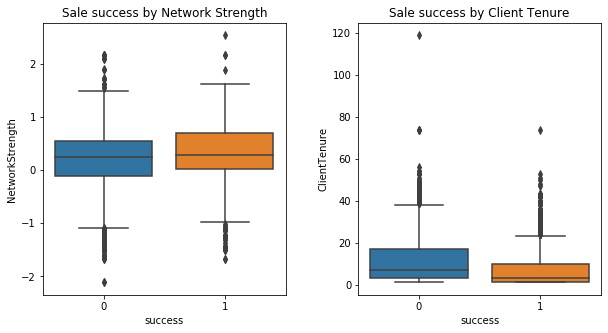

In [19]:
# Continous features
plt.subplot(1,2,1)
sns.boxplot(x='success', y="NetworkStrength", data=df_sum)
plt.title("Sale success by Network Strength")

plt.subplot(1,2,2)
sns.boxplot(x='success', y="ClientTenure", data=df_sum)
plt.title("Sale success by Client Tenure")

# Aesthestics
plt.subplots_adjust(wspace = 0.3, hspace = 0)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

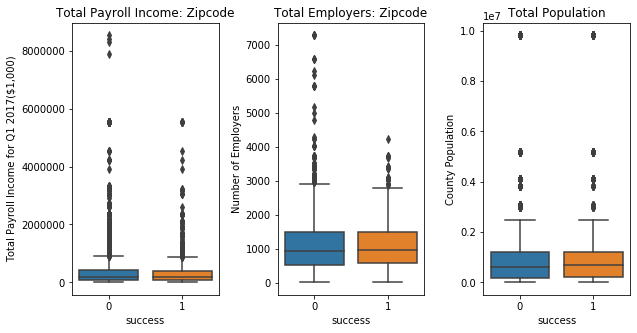

In [20]:
# County Business indicators
plt.subplot(1,3,1)
sns.boxplot(x='success', y="tot_payroll_q1", data=df_sum)
plt.title("Total Payroll Income: Zipcode")
plt.ylabel('Total Payroll Income for Q1 2017($1,000)')

plt.subplot(1,3,2)
sns.boxplot(x='success', y="tot_employers", data=df_sum)
plt.title("Total Employers: Zipcode")
plt.ylabel('Number of Employers')

plt.subplot(1,3,3)
sns.boxplot(x='success', y="population",data=df_sum)
plt.title("Total Population")
plt.ylabel('County Population')

plt.subplots_adjust(wspace= 0.4, hspace = 0.1)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

# Machine Learning Preparation
* Inbalanced classes
* One-hot-encoding

Text(0, 0.5, 'Count of observations')

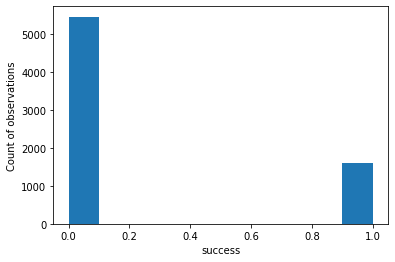

In [21]:
# Check for inbalanced classes
plt.hist(df_sum.success)
plt.xlabel("success")
plt.ylabel("Count of observations")

In [22]:
# Rebalancing of classes
# generate special classes for types
count0, count1 = df_sum.success.value_counts()
aclass0 = df_sum[df_sum.success==0]
aclass1 = df_sum[df_sum.success==1]
print(count0)
print(count1)

5460
1615


5460


(array([5460.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5460.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

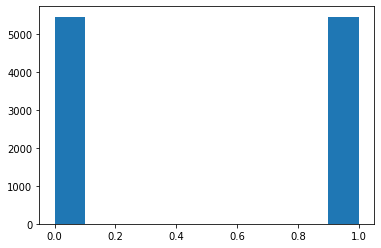

In [23]:
# over sampling for class 1 
# Generate a new sample of count0 items of count1
over1 = aclass1.sample(count0,replace=True)
df_sum = pd.concat([aclass0,over1],axis=0)
print(len(over1))
plt.hist(df_sum.success)

# Random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the
# minority class examples. In this way, a symbolic classifier, for instance, might construct rules that are
# apparently accurate, but actually cover one replicated example.

In [24]:
df_sum.shape

(10920, 12)

In [25]:
# Drop categorical variables created: company_size & income_cat
df_ml = df_sum.drop(['company_size', 'income_cat'], axis=1)
# One-hot encoding: state & industry
df_ml = pd.get_dummies(df_ml, prefix=['state', 'industry'], columns=['state', 'Industry'])
df_ml.shape

(10920, 87)

In [26]:
# Create y and X features: *important step*
y = df_ml['success']
X = df_ml.iloc[:, 1:] 

In [27]:
# X features
X.columns

Index(['NetworkStrength', 'ClientTenure', 'Employees', 'population',
       'tot_payroll_q1', 'tot_payroll_annual', 'tot_employers', 'state_AK',
       'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY', 'industry_I01', 'industry_I02', 'industry_I03',
       'industry_I04', 'industry_I05', 'industry_I06', 'industry_I07',
       'industry_I08', 'industry_I09', 'industry_I10', 'industry_I11',
  

In [28]:
# y feature
y.name

'success'

In [29]:
# Set up Monte-carlo experiment
def MCtraintest(nmc,X,y,modelObj,testFrac):
    trainScore = np.zeros(nmc)
    testScore  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testFrac)
        modelObj.fit(X_train,y_train)
        trainScore[i] = modelObj.score(X_train,y_train)
        testScore[i]  = modelObj.score(X_test,y_test)
    return trainScore,testScore

# Set parameters 
nmc = 100
testFrac = 0.25

# Machine Learning Models

## Ridge

In [30]:
from sklearn.linear_model import Ridge

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), Ridge(alpha=10))
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.0967


## Lasso

In [31]:
from sklearn.linear_model import Lasso

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=100000))
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.0918


## Logistic Regression
* Default parameters
* Grid search
* Best Model
* Model interpretation: Coefficients

In [32]:
from sklearn.linear_model import LogisticRegression

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.6379


In [99]:
# Grid search
clist = np.power(10.,range(-8,2))
fullModel = make_pipeline(StandardScaler(),LogisticRegression())
# set up dictionary for grid search
# dictionary name must now include pipeline function name then __
param_grid={'logisticregression__C':clist,'logisticregression__max_iter':[3000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_logisticregression__C']]

# Highlight Orange best model Function
def highlight_col(x):
    # copy df to new - original data are not changed
    df = x.copy()
    # Hightlight orange highest ranked model
    mask = df['rank_test_score'] == 1
    df.loc[mask, :] = 'background-color: orange'
    df.loc[~mask,:] = 'background-color: ""'
    return df 

# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_logisticregression__C
0,10,0.505324,0.496278,0.000000
1,9,0.506458,0.497619,0.000000
2,8,0.521335,0.511810,0.000001
3,7,0.620728,0.610894,0.000010
4,1,0.645490,0.638974,0.000100
5,2,0.645797,0.638864,0.001000
6,6,0.646067,0.638242,0.010000
7,3,0.646835,0.638839,0.100000
8,5,0.646816,0.638751,1.000000
9,4,0.646802,0.638828,10.000000


Text(0.5, 1.0, 'Regularization in Logistic Regression')

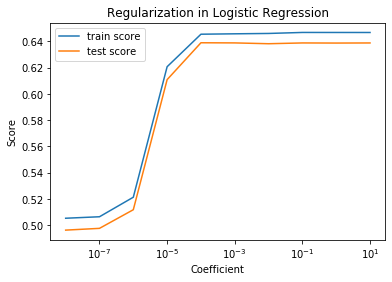

In [100]:
# Regularization Plot
plt.semilogx(clist, df_results['mean_train_score'],label="train score")
plt.semilogx(clist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in Logistic Regression")

## Nearest Neighbour
* Default parameters
* Grid search
* Best Model

In [35]:
from sklearn.neighbors import KNeighborsClassifier

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), KNeighborsClassifier())
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.7079


Text(0.5, 1.0, 'Regularization in Nearest Neighbour')

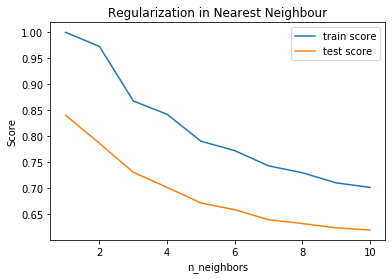

In [112]:
# Grid search:
neighborRange = np.arange(1,11)
trainList = np.zeros(len(neighborRange))
testList  = np.zeros(len(neighborRange))
for j in neighborRange:
    knnc = KNeighborsClassifier(n_neighbors=j)
    trainScore,testScore = MCtraintest(100,X,y,knnc,0.25)
    trainList[j-1] = np.mean(trainScore)
    testList[j-1] = np.mean(testScore)
    
plt.plot(neighborRange,trainList,label="train score")
plt.plot(neighborRange,testList,label="test score")
plt.ylabel("Score")
plt.xlabel("n_neighbors")
plt.legend()
plt.title("Regularization in Nearest Neighbour")

## Suppport Vector Classifier
* Default parameters
* Grid search
* Best Model

In [37]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), LinearSVC())
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.6360


In [68]:
# Grid search 
clist = np.power(10.,range(-5,10))
fullModel = make_pipeline(StandardScaler(),LinearSVC())
# set up dictionary for grid search
# Dictionary name must now include pipeline function name then __
param_grid={'linearsvc__C':clist,'linearsvc__max_iter':[3000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_linearsvc__C']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_linearsvc__C
0,5,0.644595,0.637201,0.000010
1,1,0.645656,0.637531,0.000100
2,3,0.645711,0.637352,0.001000
3,2,0.646294,0.637396,0.010000
4,4,0.646471,0.637231,0.100000
5,6,0.646237,0.637070,1.000000
6,7,0.636186,0.627930,10.000000
7,8,0.567946,0.564015,100.000000
8,11,0.548347,0.545810,1000.000000
9,13,0.548071,0.543747,10000.000000


Text(0.5, 1.0, 'Regularization in Logistic Regression')

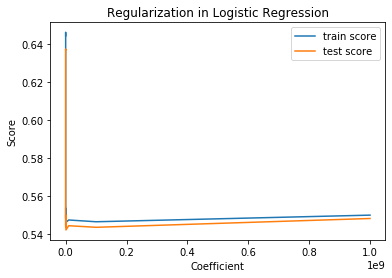

In [76]:
# Regularization Plot
plt.plot(clist, df_results['mean_train_score'],label="train score")
plt.plot(clist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in SVC")

##  Naive Bayes Classifier
* Verify Gaussian assumptions
* Default parameters
* Grid search
* Best Model

In [40]:
# Verify model assumptions
# Check for multicolinearity: VIF > 5 not good
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = X
vif = pd.DataFrame()
X_vif = X_vif.assign(const=1)
vif["vif_factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif.sort_values("vif_factor").round(3)

,vif_factor,features
86,0.000,const
2,1.007,Employees
1,1.145,ClientTenure
0,1.720,NetworkStrength
3,1.805,population
...,...,...
28,NaN,state_ME
33,NaN,state_MT
37,NaN,state_NH
46,NaN,state_RI


In [41]:
# Default parameters
from sklearn.naive_bayes import GaussianNB

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), GaussianNB())
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.5207


## Linear Discriminant Classifier

* Default parameters


In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.6362


## Quadratic Discriminant Classifier
* Default parameters

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

cvshuffle = ShuffleSplit(n_splits=100, test_size=.25)
fullModel = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
testS = cross_val_score(fullModel, X, y, cv=cvshuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(testS)))

Testing Set Accuracy: 0.5412


## Decision Trees
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Tree
    * Model importances

In [44]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
CVScores = cross_val_score(dt, X, y, cv=shuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVScores)))

Testing Set Accuracy: 0.8536


In [89]:
# Grid Search
# Parameters
tree_depth = np.arange(start=2,stop=51,step=2,dtype=int)
param_grid={'max_depth':tree_depth}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(DecisionTreeClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth
0,25,0.618501,0.618476,2
1,24,0.640201,0.632637,4
2,23,0.667559,0.646359,6
3,22,0.701377,0.666275,8
4,21,0.740493,0.690546,10
5,20,0.785365,0.717560,12
6,19,0.829663,0.744179,14
7,18,0.868589,0.767044,16
8,17,0.902133,0.787960,18
9,16,0.928212,0.804663,20


Text(0.5, 1.0, 'Regularization in Decision Trees')

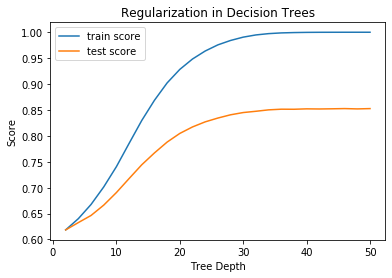

In [90]:
# Plot
plt.plot(tree_depth, df_results['mean_train_score'],label="train score")
plt.plot(tree_depth, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Tree Depth")
plt.legend()
plt.title("Regularization in Decision Trees")

In [94]:
# Analyze tree
X_train, X_test, y_train, y_test = train_test_split(X,y)
dt = DecisionTreeClassifier(max_depth=4, random_state=0)
dt.fit(X_train, y_train)

print("Training Set Accuracy: {:.4f}".format(dt.score(X_train, y_train)))
print("Testing Set Accuracy: {:.4f}".format(dt.score(X_test, y_test)))

Training Set Accuracy: 0.6402
Testing Set Accuracy: 0.6414


In [95]:
# Tree
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file="tree.dot", class_names=["Lost", "Sold"],
                feature_names= X.columns, impurity=False, filled=True)

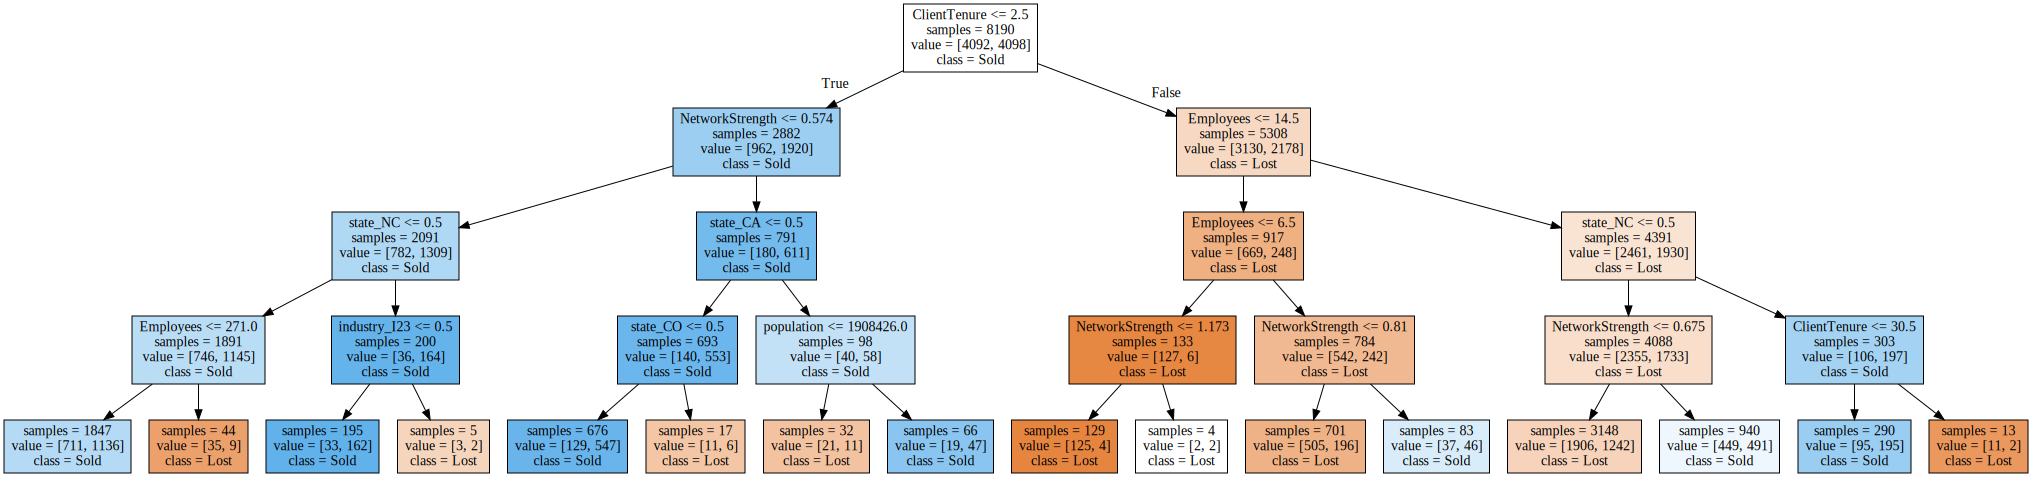

In [96]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

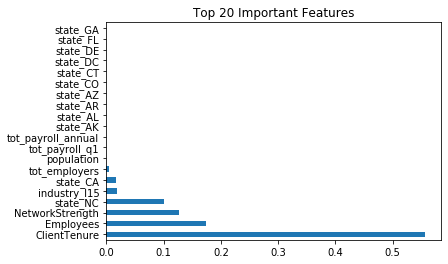

In [50]:
# Feature importances
def plot_feature_importances(model):
    # Calculate feature importances
    importances = model.feature_importances_
    # Sort feature importances in descending order
    # Rearrange feature names so they match the sorted feature importances
    # Filter for top 20 importances
    (pd.Series(model.feature_importances_, index=X.columns)
    # Filter for top 20 importances
    .nlargest(20)
    .plot(kind='barh'))
    plt.title("Top 20 Important Features")
plot_feature_importances(dt)

## Random Forests
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Model Importances

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
CVScores = cross_val_score(rf, X, y, cv=shuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVScores)))

Testing Set Accuracy: 0.9085


In [104]:
# Grid search
max_features_list = np.arange(start=1,stop= 11,step=1,dtype=int)
tree_depth_list   = np.arange(start=1,stop= 11,step=2,dtype=int)
# Set grid search
param_grid={'max_features':max_features_list,'max_depth':tree_depth_list,'n_estimators':[50]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth', 'param_max_features', 'param_n_estimators']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth,param_max_features,param_n_estimators
0,50,0.588087,0.577989,1,1,50
1,49,0.612065,0.604553,1,2,50
2,48,0.623333,0.616436,1,3,50
3,47,0.628573,0.622879,1,4,50
4,46,0.630104,0.625092,1,5,50
5,45,0.630449,0.626524,1,6,50
6,41,0.631934,0.628996,1,7,50
7,43,0.630383,0.627341,1,8,50
8,42,0.631448,0.627370,1,9,50
9,44,0.630189,0.627066,1,10,50


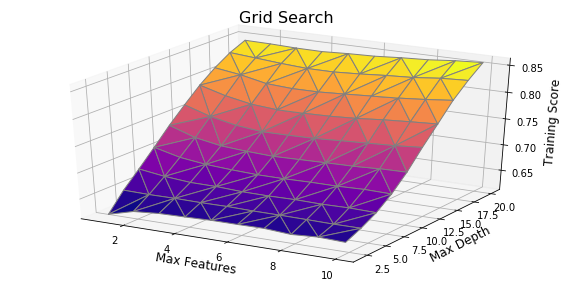

In [102]:
# 3D plot of Grid search results
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = df_results['param_max_features']
ys = df_results['param_max_depth']
zs = df_results['mean_test_score']

ax.set_xlabel("Max Features",fontsize = 12)
ax.set_ylabel("Max Depth",fontsize = 12)
ax.set_zlabel("Training Score", fontsize = 12)
ax.set_title("Grid Search", fontsize = 16)

# Aesthetics
fig.set_figheight(5)
fig.set_figwidth(10)
                   
ax.plot_trisurf(xs, ys, zs,color= 'blue',edgecolor='gray', cmap=cm.plasma)

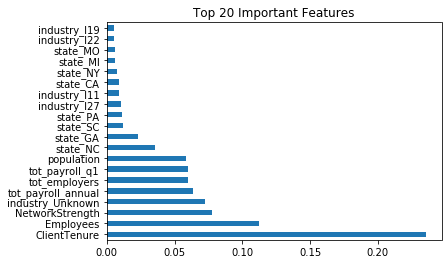

In [54]:
# Best Model and Feature importances
X_train, X_test, y_train, y_test = train_test_split(X,y)
rf = RandomForestClassifier(n_estimators=50,max_features=10,max_depth=10)
rf.fit(X_train, y_train)
plot_feature_importances(rf)

## Boosted Trees
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Model Importances
    * Partial Dependence

In [55]:
# Default parameters
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
CVScores = cross_val_score(gb, X, y, cv=shuffle)
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVScores)))

Testing Set Accuracy: 0.6833


In [113]:
# Grid search
# set up dictionary for grid search
param_grid={'n_estimators':[10,25,50,75],'max_depth':[2,3,4],'learning_rate':[0.1,0.2,0.3,0.5]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# Select relevant columns
df_results_gb = results[['rank_test_score','mean_train_score','mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate']]
# Table for Grid search results
df_results_gb.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_learning_rate
0,48,0.629371,0.625648,10,2,0.100000
1,45,0.645656,0.640469,25,2,0.100000
2,41,0.657860,0.649374,50,2,0.100000
3,36,0.666353,0.654832,75,2,0.100000
4,47,0.643000,0.635604,10,3,0.100000
5,40,0.660427,0.649505,25,3,0.100000
6,31,0.680037,0.661590,50,3,0.100000
7,23,0.697048,0.672952,75,3,0.100000
8,42,0.661635,0.648692,10,4,0.100000
9,29,0.683203,0.662875,25,4,0.100000


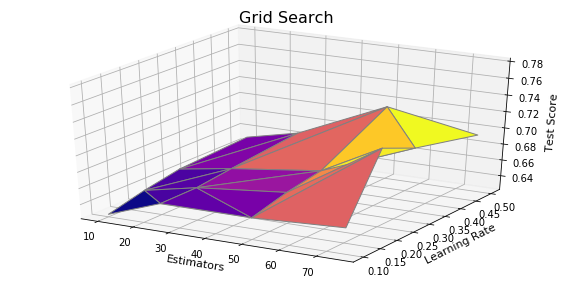

In [115]:
# 3D plot of Grid search results
# Colormap reference module
from matplotlib import cm 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = df_results_gb['param_n_estimators']
ys = df_results_gb['param_learning_rate']
zs = df_results_gb['mean_test_score']

ax.set_xlabel("Estimators",fontsize = 11)
ax.set_ylabel("Learning Rate",fontsize = 11)
ax.set_zlabel("Test Score", fontsize = 11)
ax.set_title("Grid Search", fontsize = 16)

# Aesthetics
fig.set_figheight(5)
fig.set_figwidth(10)
                
ax.plot_trisurf(xs, ys, zs,color= 'blue',edgecolor='gray', cmap=cm.plasma)

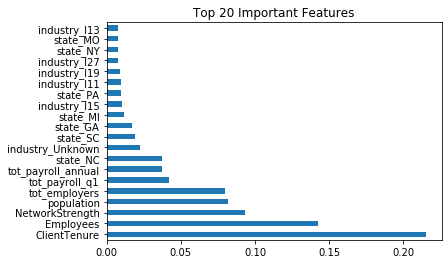

In [58]:
# Best Model and Feature importance
X_train, X_test, y_train, y_test = train_test_split(X,y)
gb = GradientBoostingClassifier(n_estimators=75,learning_rate = 0.2,max_depth=4)
gb.fit(X_train, y_train)
plot_feature_importances(gb)

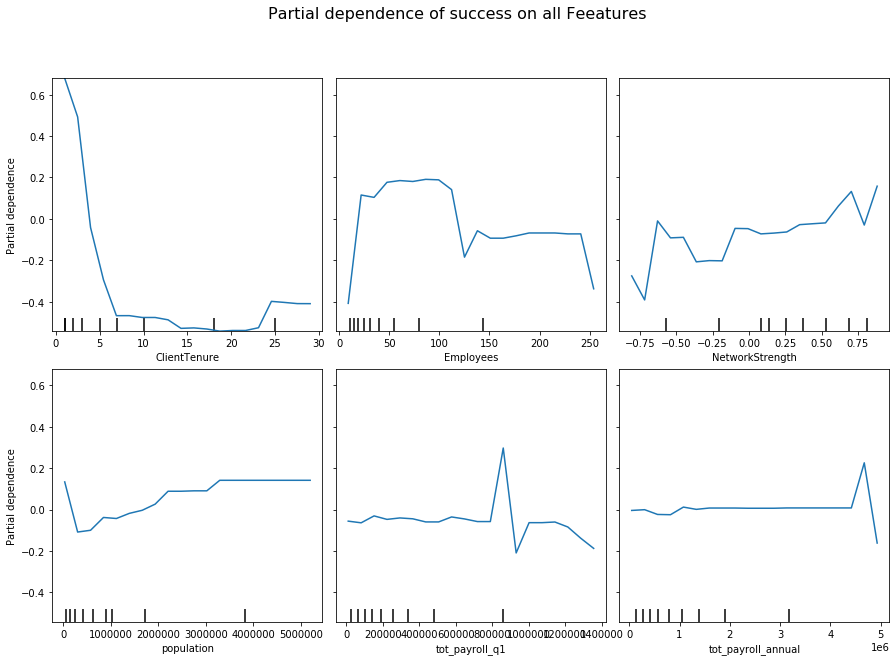

In [59]:
# Partial dependence plot

# Partial dependence plot module
from sklearn.inspection import plot_partial_dependence

# Order plots by feuture importance 
features = [1,2,0,3,4,5]
plot_partial_dependence(gb,X,features, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of success on all Feeatures',fontsize=16)
fig.subplots_adjust(wspace= 0.05, hspace=0.15)
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Neural Networks
* Default parameters
* Grid search
* Best Model
* Model Interpretation

# Evaluation of Metrics
* Confusion Matrix of Best Model
* Threshold Changes
* ROC Curve

In [60]:
# Boosted Tree
yhat = gb.predict(X_test)
cmat = confusion_matrix(y_test,yhat)
print(cmat)
tn, fp, fn, tp = cmat.ravel()
print("True Negatives:", tn, "False Positives:", fp, "False Neagtives:", fn, "True positive:", tp)

[[ 977  404]
 [ 297 1052]]
True Negatives: 977 False Positives: 404 False Neagtives: 297 True positive: 1052


In [61]:
# The basic values
# General accuracy
accuracy = (tp+tn)/(tp+tn+fp+fn)
# fraction of positives that are actually positive
precision = tp/(tp+fp)
# fraction of positives (power)
recall = tp/(tp+fn)
type2 = 1 - recall # type 2 error rate (1-power)
# false positive rate (size or type I error)
fpr = fp/(fp+tn)
# Some counts on errors for stats types
type1errors = fp # reject(1) true(0)
type2errors = fn # don't reject(0) true 1
print((accuracy, precision, recall, fpr))

(0.7432234432234432, 0.7225274725274725, 0.7798369162342476, 0.29254163649529324)


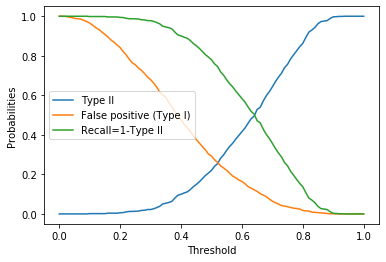

In [67]:
# This code plots type2errors, faslse positives, and recals against thesholds
thresholds = np.arange(start=0.,stop=1.01,step=0.01)
recallList = []
type2List = []
fpList = []
# make sure probs are ok
yhatp = gb.predict_proba(X_test)
for thresh in thresholds:
    yhat = yhatp[:,1]>thresh
    cmat = confusion_matrix(y_test,yhat)
    tn, fp, fn, tp = cmat.ravel()
    recallList.append( tp/(tp+fn))
    fpList.append(fp/(fp+tn))
    type2List.append(fn/(tp+fn))
plt.plot(thresholds,type2List,label='Type II')
plt.plot(thresholds,fpList,label='False positive (Type I)')
plt.plot(thresholds,recallList,label='Recall=1-Type II')
plt.xlabel('Threshold')
plt.ylabel('Probabilities')
plt.legend()

Text(0.5, 1.0, 'ROC Curve')

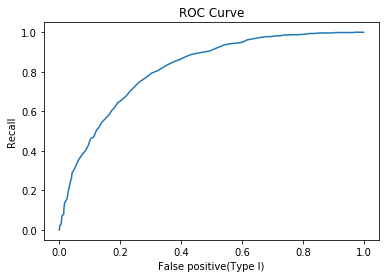

In [63]:
# Plot roc curve
plt.plot(fpList,recallList)
plt.xlabel('False positive(Type I)')
plt.ylabel('Recall')
plt.title('ROC Curve')

# Insights
* Highest accuracy achieved with Decision Trees, Random Forest, and Logistic Regression
* Feature importances also show similar patterns
* **Employees** and **ClientTenure** are consistently the most importances features in all tree-based models
* Decision Tree suggests targeting employers whose **ClientTenure** is low for increased sales of **ProductX**
* Partial dependence plot in Boosted Tree shows an initial linear relationship between sale success and employee headcount with a sharp downward trend starting from circa 60 **Employees**. This suggests higher payoff when targeting *micro*, *small* and *medium* employers